In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle

In [3]:
df = pd.read_csv("feature_selected_data.csv")
df

,VehPower,VehAge,DrivAge,Area,VehBrand,VehGas,Region,ClaimFrequency,VehPowerDriverAge,TransformBonusMalus,TransformDensity,isClaim
0,5.0,0.0,55.0,D,B12,Regular,R82,1.000000,0.090909,3.912023,7.104144,1
1,5.0,0.0,55.0,D,B12,Regular,R82,1.298701,0.090909,3.912023,7.104144,1
2,6.0,2.0,52.0,B,B12,Diesel,R22,1.333333,0.115385,3.912023,3.988984,1
3,7.0,0.0,46.0,B,B12,Diesel,R72,1.190476,0.152174,3.912023,4.330733,1
4,6.0,2.0,38.0,E,B12,Regular,R31,1.923077,0.157895,3.912023,8.007367,1
...,...,...,...,...,...,...,...,...,...,...,...,...
677997,4.0,0.0,54.0,E,B12,Regular,R93,0.000000,0.074074,3.912023,8.106816,0
677998,4.0,0.0,41.0,E,B12,Regular,R11,0.000000,0.097561,4.553877,9.195227,0
677999,6.0,2.0,45.0,D,B12,Diesel,R82,0.000000,0.133333,3.912023,7.187657,0
678000,4.0,0.0,60.0,B,B12,Regular,R26,0.000000,0.066667,3.912023,4.553877,0


### Preprocessing

In [ ]:
X = df.drop(columns=['ClaimFrequency', "isClaim"])
y = df['ClaimFrequency']

# Convert target to binary for classification step
y_class = df["isClaim"]

# Split data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X[y > 0], y[y > 0], test_size=0.2, random_state=42)

# Define numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])

### Classification

In [ ]:
# Classification Model (with SMOTE for imbalance handling)
classifier_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Hyperparameter tuning for classification model
param_grid_class = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

In [13]:
X_train_class

,VehPower,VehAge,DrivAge,Area,VehBrand,VehGas,Region,VehPowerDriverAge,TransformBonusMalus,TransformDensity,isClaim
161570,5.0,6.0,42.0,D,B5,Diesel,R54,0.119048,4.143135,6.722630,0
13860,6.0,3.0,36.0,C,B1,Diesel,R24,0.166667,3.912023,4.653960,0
269882,11.0,11.0,34.0,D,B1,Diesel,R82,0.323529,3.988984,7.476472,0
488313,5.0,0.0,38.0,E,B2,Diesel,R93,0.131579,4.553877,8.106816,0
420318,5.0,13.0,24.0,E,B5,Diesel,R73,0.208333,4.553877,7.659171,0
...,...,...,...,...,...,...,...,...,...,...,...
259178,7.0,0.0,39.0,C,B3,Diesel,R82,0.179487,4.043051,4.969813,0
365838,6.0,2.0,33.0,E,B12,Diesel,R31,0.181818,4.276666,8.037543,0
131932,10.0,12.0,48.0,E,B2,Diesel,R93,0.208333,3.912023,8.227910,0
671155,5.0,1.0,42.0,C,B12,Regular,R11,0.119048,4.276666,5.572154,0


In [8]:
grid_search_class = GridSearchCV(classifier_pipeline, param_grid_class, cv=5, scoring='roc_auc')
grid_search_class.fit(X_train_class, y_train_class)

best_classifier = grid_search_class.best_estimator_
y_pred_class = best_classifier.predict(X_test_class)
print(f"Best Classification Model: {grid_search_class.best_params_}")
print(f"Classification Accuracy: {accuracy_score(y_test_class, y_pred_class)}")
print(f"ROC AUC: {roc_auc_score(y_test_class, y_pred_class)}")

Best Classification Model: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Classification Accuracy: 1.0
ROC AUC: 1.0


In [11]:
with open('best_classifier.pkl','wb') as f:
    pickle.dump(best_classifier,f)

# load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

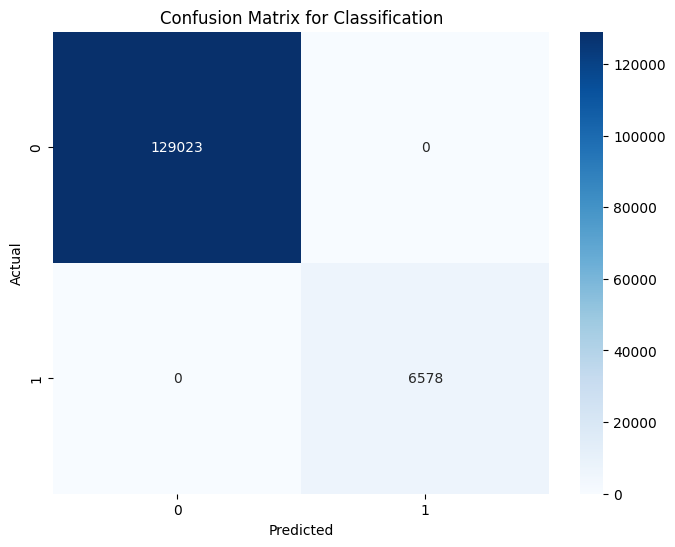

In [12]:
# Classification Evaluation Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_class, y_pred_class), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Classification')
plt.show()

### Regression

In [ ]:
# Regression Model (only on positive claim cases)
regressor_pipeline = Pipeline([
    ('preprocess', preprocessor),
    # ('regressor', RandomForestRegressor(random_state=42)) # Change !!!!!
])

# Hyperparameter tuning for regression model
param_grid_reg = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

In [ ]:
grid_search_reg = GridSearchCV(regressor_pipeline, param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_reg.fit(X_train_reg, y_train_reg)

best_regressor = grid_search_reg.best_estimator_
y_pred_reg = best_regressor.predict(X_test_reg)
print(f"Best Regression Model: {grid_search_reg.best_params_}")
print(f"Regression RMSE: {mean_squared_error(y_test_reg, y_pred_reg, squared=False)}")

In [ ]:
# Regression Evaluation Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg)
plt.xlabel("Actual Claim Frequency")
plt.ylabel("Predicted Claim Frequency")
plt.title("Regression Model Predictions vs Actuals")
plt.show()

In [ ]:
# Final Prediction Pipeline
class_preds = best_classifier.predict(X_test)
final_preds = np.where(class_preds == 1, best_regressor.predict(X_test), 0)

In [ ]:
# Final Model Evaluation Visualization
plt.figure(figsize=(8, 6))
sns.histplot(final_preds, bins=50, kde=True, color='blue', label='Predicted')
sns.histplot(y_test_class * y_test_reg, bins=50, kde=True, color='red', label='Actual')
plt.xlabel("Claim Frequency")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs Predicted Claim Frequency")
plt.show()